## Project (Modeling OSW Transmission Configurations for Oregon Call Areas with PyPSA-USA)




In [311]:
# Install dependencies
!pip install pypsa matplotlib cartopy xarray==2023.9.0

In [312]:
# Import packages
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
import copy
import gurobipy

In [313]:
# Import network
network = pypsa.Network('elec_s_30.nc')

INFO:pypsa.io:Imported network elec_s_30.nc has buses, carriers, generators, lines, links, loads, storage_units


In [314]:
# Turn off p_nom_extendable
network.generators = network.generators.assign(p_nom_extendable = False)

In [315]:
# Modify load data to 2030
load_growth = 1.22 # growth factor assumption made using AAGR from PGE (Portland General Electric)
#network.loads_t.p_set /= load_growth # to reset when load_growth is changed
network.loads_t.p_set *= load_growth # modify load data
#print(network.loads_t.p_set)

In [316]:
# Add buses for the generators
network.add("Bus", "Coos_Bay_bus", x=-124.6055473 , y=43.34295325, v_nom=230)
network.add("Bus", "Brookings_bus", x=-124.5635892, y=42.04583839, v_nom=230)

In [317]:
# Define OSW generator parameters
gen = "Generator" # type of thing, for first line of add
efficiency = 0.59

# OSW generator 1: Coos Bay

gen_1_name = "Coos_Bay"
gen_1_bus = "Coos_Bay_bus"
gen_1_p_nom = 941 # MW

# Import p_max_pu data
Coos_Bay_net_CF = pd.read_excel('Coos_Bay_p_max_pu.xlsx',index_col=0) # import for p_max_pu, time series, net CF
network.import_series_from_dataframe(
        pd.DataFrame(Coos_Bay_net_CF,
            columns=network.generators.index, index=network.snapshots),
                    "Generator",
                    "p_max_pu")

# OSW generator 2: Brookings

gen_2_name = "Brookings"
gen_2_bus = "Brookings_bus"
gen_2_p_nom = 613 # MW

# Import p_max_pu data
Brookings_net_CF = pd.read_excel('Brookings_p_max_pu.xlsx',index_col=0) # import for p_max_pu: time series, net CF
network.import_series_from_dataframe(
        pd.DataFrame(Brookings_net_CF,
            columns=network.generators.index, index=network.snapshots),
                    "Generator",
                    "p_max_pu")

# Convert p_max_pu to time series for other generators
exclude_generators = ["Coos_Bay", "Brookings"]
for gen_name in network.generators.index:
    if gen_name not in exclude_generators:
        network.generators_t.p_max_pu[gen_name] = 1.0

In [318]:
# Add OSW generators

# OSW generator 1: Coos Bay

network.add(
    gen,
    gen_1_name,
    bus = gen_1_bus,
    carrier = "offwind",
    p_nom = gen_1_p_nom,  
    p_nom_extendable = False,
    marginal_cost = 0,
)

network.generators_t.p_max_pu[gen_1_name] = Coos_Bay_net_CF[gen_1_name]

# OSW generator 2: Brookings

network.add(
    gen,
    gen_2_name,
    bus = gen_2_bus,
    carrier = "offwind",
    p_nom = gen_2_p_nom,  
    p_nom_extendable = False,
    marginal_cost = 0,
)

network.generators_t.p_max_pu[gen_2_name] = Brookings_net_CF[gen_2_name]

/var/folders/h_/mkzhg7jx1yl_9mzyfvtm94zm0000gn/T/ipykernel_51426/408822868.py:15: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/h_/mkzhg7jx1yl_9mzyfvtm94zm0000gn/T/ipykernel_51426/408822868.py:29: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [155]:
# Define transmission line parameters
reactance = 5.5 # Ohm
#resistance = 0.04790403098
Coos_to_Wendson = 88 # km
Brookings_to_Fairview = 135 # km
Coos_to_Brookings = 144 # km
Coos_to_Fairview = 42 # km

In [156]:
# Create radial AC transmission layout
AC_radial = copy.deepcopy(network)

AC_radial.add(
    "Line",
    "Coos-Onshore_AC",
    bus0 = "Coos_Bay_bus",
    bus1 = "BPAT0 0",
    x = reactance,
    #r = resistance,
    s_nom = gen_1_p_nom,
    s_max_pu = 0.7,
    length = Coos_to_Wendson,
    carrier = "AC"
)

AC_radial.add(
    "Line",
    "Brookings-Onshore_AC",
    bus0 = "Brookings_bus",
    bus1 = "PACW0 0",
    x = reactance,
    #r = resistance,
    s_nom = gen_2_p_nom,
    s_max_pu = 0.7,
    length = Brookings_to_Fairview,
    carrier = "AC"
)

In [157]:
# Create radial DC transmission layout
DC_radial = copy.deepcopy(network)
p_nom_value = 3000 # MW

DC_radial.add(
    "Link",
    "Coos-Onshore_DC",
    bus0 = "Coos_Bay_bus",
    bus1 = "BPAT0 0",
    p_nom = p_nom_value,
    carrier = "DC",
    length = Coos_to_Wendson,
    p_max_pu = 0.7
)

DC_radial.add(
    "Link",
    "Brookings-Onshore_DC",
    bus0 = "Brookings_bus",
    bus1 = "PACW0 0",
    p_nom = p_nom_value,
    carrier = "DC",
    length = Brookings_to_Fairview,
    p_max_pu = 0.7
)

In [158]:
# Create DC backbone transmission layout
DC_backbone = copy.deepcopy(network)

DC_backbone.add(
    "Link",
    "Backbone_DC",
    bus0 = "Coos_Bay_bus",
    bus1 = "Brookings_bus",
    p_nom = p_nom_value,
    carrier = "DC",
    length = Coos_to_Brookings,
    p_max_pu = 0.7
)

DC_backbone.add(
    "Link",
    "Coos-Fairview_DC",
    bus0 = "Coos_Bay_bus",
    bus1 = "PACW0 0",
    p_nom = p_nom_value,
    carrier = "DC",
    length = Coos_to_Fairview,
    p_max_pu = 0.7
)

In [159]:
# Add load shedding
AC_radial.optimize.add_load_shedding(sign=1, marginal_cost=10000,suffix=' load')
DC_radial.optimize.add_load_shedding(sign=1, marginal_cost=10000,suffix=' load')
DC_backbone.optimize.add_load_shedding(sign=1, marginal_cost=10000,suffix=' load')

Index(['0 0 load', 'AVA0 0 load', 'Arizona0 0 load', 'BANC0 0 load',
       'BPAT0 0 load', 'CHPD0 0 load', 'CISO-PGAE0 0 load', 'CISO-SCE0 0 load',
       'CISO-SCE0 1 load', 'CISO-SDGE0 0 load', 'CISO-VEA0 0 load',
       'DOPD0 0 load', 'EPE0 0 load', 'GCPD0 0 load', 'GRID0 0 load',
       'IID0 0 load', 'IPCO0 0 load', 'LDWP0 0 load', 'NEVP0 0 load',
       'NWMT0 0 load', 'PACE0 0 load', 'PACW0 0 load', 'PGE0 0 load',
       'PNM0 0 load', 'PSCO0 0 load', 'PSEI0 0 load', 'TEPC0 0 load',
       'TIDC0 0 load', 'WACM0 0 load', 'WALC0 0 load', 'WAUW0 0 load',
       'Coos_Bay_bus load', 'Brookings_bus load'],
      dtype='object', name='Bus')

In [160]:
# Optimize AC radial
AC_radial.optimize(AC_radial.snapshots,solver_name="gurobi")

Index(['Coos-Onshore_AC', 'Brookings-Onshore_AC'], dtype='object', name='Line')
Index(['Coos-Onshore_AC', 'Brookings-Onshore_AC'], dtype='object', name='Line')
/Users/selmasharaf/opt/anaconda3/envs/pypsa-usa/lib/python3.11/site-packages/linopy/expressions.py:176: FutureWarning:

the `pandas.MultiIndex` object(s) passed as 'Generator' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.

/Users/selmasharaf/opt/anaconda3/envs/pypsa-usa/lib/python3.11/site-packages/linopy/expressions.py:176: FutureWarning:

the `pandas.MultiI

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-03


Writing continuous variables.: 100%|██████████████| 9/9 [00:11<00:00,  1.24s/it]


Read LP format model from file /private/var/folders/h_/mkzhg7jx1yl_9mzyfvtm94zm0000gn/T/linopy-problem-y1kve7fb.lp
Reading time = 26.54 seconds
obj: 7367166 rows, 2784570 columns, 12901224 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i3-1000NG4 CPU @ 1.10GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 7367166 rows, 2784570 columns and 12901224 nonzeros
Model fingerprint: 0xfaac19e8
Coefficient statistics:
  Matrix range     [6e-01, 2e+03]
  Objective range  [1e+00, 5e+08]
  Bounds range     [2e+12, 2e+12]
  RHS range        [3e-02, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 6162570 rows and 1 columns (presolve time = 7s) ...
Presolve removed 6162570 rows and 174581 columns (presolve time = 10s) ...
Presolve removed 6171371 rows and 550000 columns (presolve time = 15s) ...
Presolve removed 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2784570 primals, 7367166 duals
Objective: 4.45e+08
Solver model: available
Solver message: 2

/Users/selmasharaf/opt/anaconda3/envs/pypsa-usa/lib/python3.11/site-packages/linopy/common.py:124: UserWarning:

Coordinates across variables not equal. Perform outer join.

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Line-fix-s-lower, Line-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [161]:
# Optimize DC radial
DC_radial.optimize(DC_radial.snapshots,solver_name="gurobi")

/Users/selmasharaf/opt/anaconda3/envs/pypsa-usa/lib/python3.11/site-packages/linopy/expressions.py:176: FutureWarning:

the `pandas.MultiIndex` object(s) passed as 'Generator' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.

/Users/selmasharaf/opt/anaconda3/envs/pypsa-usa/lib/python3.11/site-packages/linopy/expressions.py:176: FutureWarning:

the `pandas.MultiIndex` object(s) passed as 'StorageUnit' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-03


Writing continuous variables.: 100%|██████████████| 9/9 [00:08<00:00,  1.12it/s]


Read LP format model from file /private/var/folders/h_/mkzhg7jx1yl_9mzyfvtm94zm0000gn/T/linopy-problem-4bsge76p.lp
Reading time = 30.99 seconds
obj: 7367166 rows, 2784570 columns, 12901224 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i3-1000NG4 CPU @ 1.10GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 7367166 rows, 2784570 columns and 12901224 nonzeros
Model fingerprint: 0x7ebf3219
Coefficient statistics:
  Matrix range     [6e-01, 2e+03]
  Objective range  [1e+00, 5e+08]
  Bounds range     [2e+12, 2e+12]
  RHS range        [3e-02, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 6162570 rows and 174581 columns (presolve time = 5s) ...
Presolve removed 6328421 rows and 707050 columns (presolve time = 11s) ...
Presolve removed 6328421 rows and 707050 columns (presolve time = 15s) ...
Presolve rem

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2784570 primals, 7367166 duals
Objective: 4.45e+08
Solver model: available
Solver message: 2

/Users/selmasharaf/opt/anaconda3/envs/pypsa-usa/lib/python3.11/site-packages/linopy/common.py:124: UserWarning:

Coordinates across variables not equal. Perform outer join.

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Line-fix-s-lower, Line-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [162]:
# Optimize DC backbone
DC_backbone.optimize(DC_backbone.snapshots,solver_name="gurobi")

/Users/selmasharaf/opt/anaconda3/envs/pypsa-usa/lib/python3.11/site-packages/linopy/expressions.py:176: FutureWarning:

the `pandas.MultiIndex` object(s) passed as 'Generator' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.

/Users/selmasharaf/opt/anaconda3/envs/pypsa-usa/lib/python3.11/site-packages/linopy/expressions.py:176: FutureWarning:

the `pandas.MultiIndex` object(s) passed as 'StorageUnit' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-03


Writing continuous variables.: 100%|██████████████| 9/9 [00:05<00:00,  1.75it/s]


Read LP format model from file /private/var/folders/h_/mkzhg7jx1yl_9mzyfvtm94zm0000gn/T/linopy-problem-7w9op0lo.lp
Reading time = 16.37 seconds
obj: 7367166 rows, 2784570 columns, 12901224 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i3-1000NG4 CPU @ 1.10GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 7367166 rows, 2784570 columns and 12901224 nonzeros
Model fingerprint: 0x1a914198
Coefficient statistics:
  Matrix range     [6e-01, 2e+03]
  Objective range  [1e+00, 5e+08]
  Bounds range     [2e+12, 2e+12]
  RHS range        [3e-02, 1e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 6171299 rows and 567386 columns (presolve time = 6s) ...
Presolve removed 6337150 rows and 733237 columns (presolve time = 10s) ...
Presolve removed 6363334 rows and 733237 columns
Presolve time: 16.67s
Presolved: 10038

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2784570 primals, 7367166 duals
Objective: 4.53e+08
Solver model: available
Solver message: 2

/Users/selmasharaf/opt/anaconda3/envs/pypsa-usa/lib/python3.11/site-packages/linopy/common.py:124: UserWarning:

Coordinates across variables not equal. Perform outer join.

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Line-fix-s-lower, Line-fix-s-upper, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, Kirchhoff-Voltage-Law, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [163]:
print("AC Radial:")
print(AC_radial.statistics().iloc[4])

print("\nDC Radial:")
print(DC_radial.statistics().iloc[4])

print("\nDC Backbone:")
print(DC_backbone.statistics().iloc[4])

AC Radial:
Capacity Factor            4.460186e-01
Capital Expenditure        0.000000e+00
Curtailment                1.904572e-06
Dispatch                   6.050182e+06
Installed Capacity         1.554000e+03
Market Value               3.035460e+00
Operational Expenditure    0.000000e+00
Optimal Capacity           1.554000e+03
Revenue                    1.836509e+07
Supply                     6.050182e+06
Withdrawal                 0.000000e+00
Name: (Generator, Offwind), dtype: float64

DC Radial:
Capacity Factor            4.268858e-01
Capital Expenditure        0.000000e+00
Curtailment                2.595341e+05
Dispatch                   5.790648e+06
Installed Capacity         1.554000e+03
Market Value               3.171508e+00
Operational Expenditure    0.000000e+00
Optimal Capacity           1.554000e+03
Revenue                    1.836509e+07
Supply                     5.790648e+06
Withdrawal                 0.000000e+00
Name: (Generator, Offwind), dtype: float64

DC Backbon

In [164]:
# Compare load costs
price_by_node_AC = AC_radial.buses_t.marginal_price
load_by_node_AC = AC_radial.loads_t.p_set.groupby(AC_radial.loads.bus, axis=1).sum()
load_costs_AC = price_by_node_AC*load_by_node_AC
total_load_cost_AC = load_costs_AC.sum().sum()

price_by_node_DC = DC_radial.buses_t.marginal_price
load_by_node_DC = DC_radial.loads_t.p_set.groupby(DC_radial.loads.bus, axis=1).sum()
load_costs_DC = price_by_node_DC*load_by_node_DC
total_load_cost_DC = load_costs_DC.sum().sum()

price_by_node_backbone = DC_backbone.buses_t.marginal_price
load_by_node_backbone = DC_backbone.loads_t.p_set.groupby(DC_backbone.loads.bus, axis=1).sum()
load_costs_backbone = price_by_node_backbone*load_by_node_backbone
total_load_cost_backbone = load_costs_backbone.sum().sum()

print("AC Radial Load Costs (MM$): ", total_load_cost_AC / 1e6)
print("DC Radial Load Costs (MM$): ", total_load_cost_DC / 1e6)
print("DC Backbone Load Costs (MM$): ", total_load_cost_backbone / 1e6)

AC Radial Load Costs (MM$):  4358.867858801609
DC Radial Load Costs (MM$):  4358.867858801609
DC Backbone Load Costs (MM$):  4408.364989204309


In [165]:
# Compare production costs
total_prod_cost_AC = (AC_radial.generators_t.p.sum(axis=0)*AC_radial.generators.marginal_cost).sum()
total_prod_cost_DC = (DC_radial.generators_t.p.sum(axis=0)*DC_radial.generators.marginal_cost).sum()
total_prod_cost_backbone = (DC_backbone.generators_t.p.sum(axis=0)*DC_backbone.generators.marginal_cost).sum()

print("AC Radial Production Costs (MM$): ", total_prod_cost_AC / 1e6)
print("DC Radial Production Costs (MM$): ", total_prod_cost_DC / 1e6)
print("DC Backbone Production Costs (MM$): ", total_prod_cost_backbone / 1e6)

AC Radial Production Costs (MM$):  451.37645384579173
DC Radial Production Costs (MM$):  451.37645384579173
DC Backbone Production Costs (MM$):  458.3542732960284


In [167]:
# Calculate annualized capital costs

lifetime = 60
rate = 0.044
miles_per_km = 0.621371
AC_cost_per_mile = 2073552.39
DC_cost_per_mile = 2*AC_cost_per_mile

# AC radial
OCC_AC = AC_cost_per_mile*((Coos_to_Wendson+Brookings_to_Fairview)*miles_per_km)
annual_cost_AC = OCC_AC*rate/(1-(1+rate)**-lifetime)
print("Annualized Line Cost of AC radial (MM$): ", annual_cost_AC / 1e6)

# DC radial
OCC_DC = DC_cost_per_mile*((Coos_to_Wendson+Brookings_to_Fairview)*miles_per_km)
annual_cost_DC = OCC_DC*rate/(1-(1+rate)**-lifetime)
print("Annualized Line Cost of DC radial (MM$): ", annual_cost_DC / 1e6)

# DC backbone
OCC_backbone = DC_cost_per_mile*((Coos_to_Brookings+Coos_to_Fairview)*miles_per_km)
annual_cost_backbone = OCC_backbone*rate/(1-(1+rate)**-lifetime)
print("Annualized Line Cost of DC backbone (MM$): ", annual_cost_backbone / 1e6)

Annualized Line Cost of AC radial (MM$):  13.674721995616446
Annualized Line Cost of DC radial (MM$):  27.349443991232892
Annualized Line Cost of DC backbone (MM$):  22.81164386712699


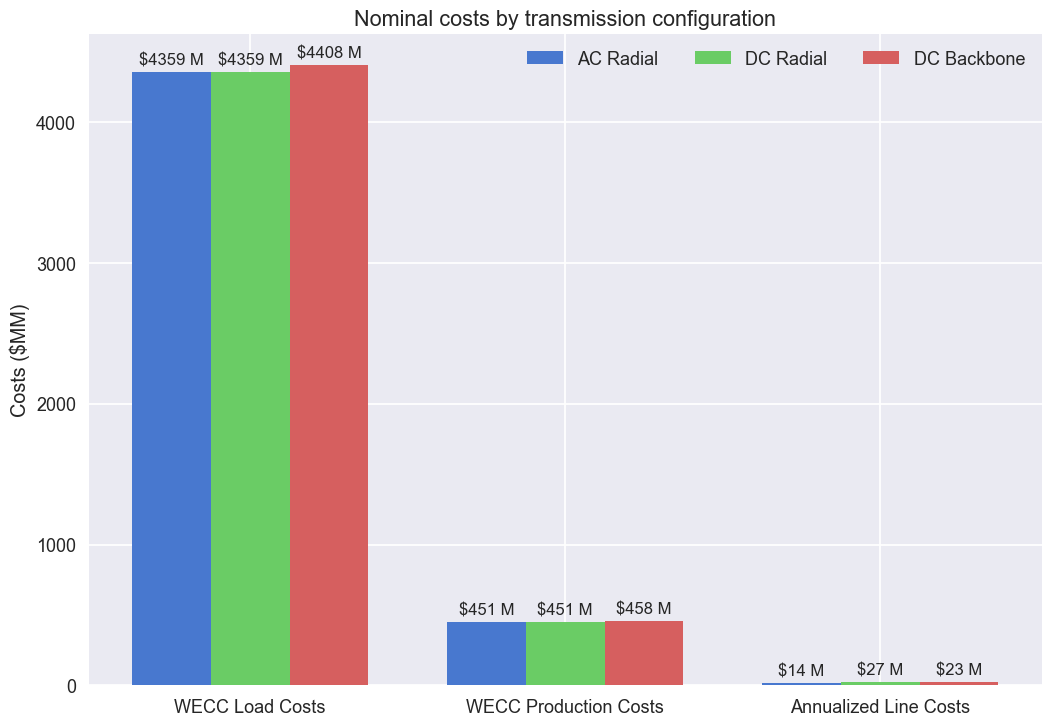

In [259]:
# Make grouped bar chart for costs
import matplotlib.pyplot as plt
import numpy as np

categories = ("WECC Load Costs", "WECC Production Costs", "Annualized Line Costs")
results = {
    'AC Radial': (total_load_cost_AC / 1e6, total_prod_cost_AC / 1e6, annual_cost_AC / 1e6),
    'DC Radial': (total_load_cost_DC / 1e6, total_prod_cost_DC / 1e6, annual_cost_DC / 1e6),
    'DC Backbone': (total_load_cost_backbone / 1e6, total_prod_cost_backbone / 1e6, annual_cost_backbone /1e6),
}

x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
plt.style.use('seaborn-v0_8-talk')

for attribute, measurement in results.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fontsize=12, fmt='$%.0f M')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Costs ($MM)')
ax.set_title('Nominal costs by transmission configuration')
ax.set_xticks(x + width, categories)
ax.legend(loc='upper right', ncols=3)

plt.show()

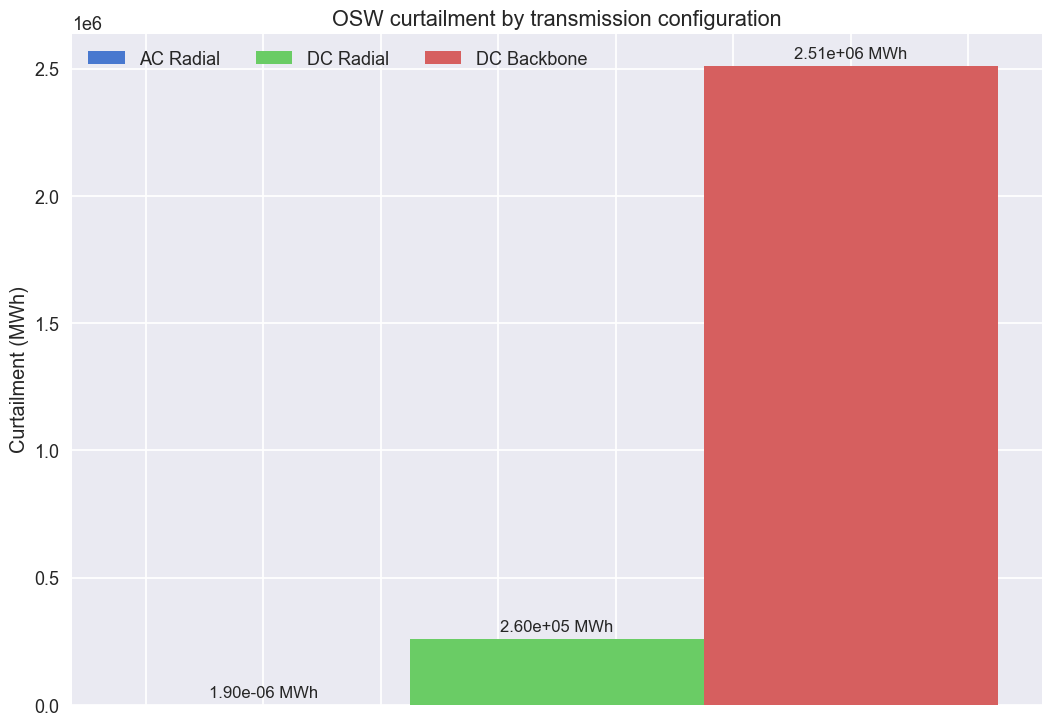

In [324]:
# Calculate and plot curtailment
curtail_AC = AC_radial.statistics.curtailment()
curtail_DC = DC_radial.statistics.curtailment()
curtail_backbone = DC_backbone.statistics.curtailment()

categories_curtail = ["Curtailment"]
results_curtail = {
    'AC Radial': (curtail_AC[[4]].iloc[0]),
    'DC Radial': (curtail_DC[[4]].iloc[0]),
    'DC Backbone': (curtail_backbone[[4]].iloc[0]),
}

x2 = np.arange(len(categories_curtail)) # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax2 = plt.subplots(layout='constrained')
plt.style.use('seaborn-v0_8-talk')

for attribute, measurement in results_curtail.items():
    offset = width * multiplier
    rects = ax2.bar(x2 + offset, measurement, width, label=attribute)
    ax2.bar_label(rects, padding=3, fontsize = 12, fmt='%.2e MWh')
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('Curtailment (MWh)')
ax2.set_title('OSW curtailment by transmission configuration')
ax2.legend(loc='upper left', ncols=3)
ax2.set(xticklabels=[])

plt.show()

/Users/selmasharaf/opt/anaconda3/envs/pypsa-usa/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



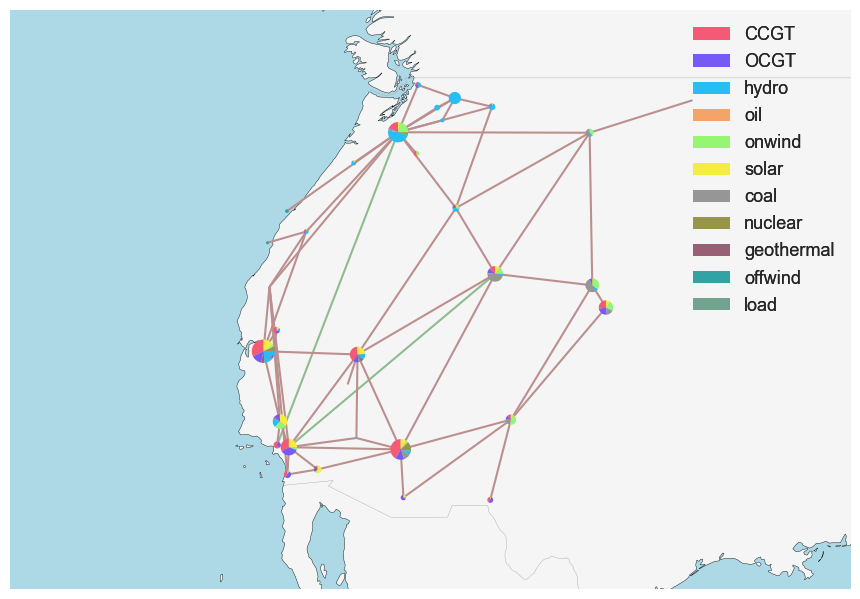

In [391]:
# Capacity map - AC Radial
from pypsa.plot import add_legend_patches
import cartopy.crs as ccrs
import random
import matplotlib.patches as mpatches

carriers = AC_radial.generators.carrier.unique()
colors = ['#F45A73','#775AF5','#27BEF5','#F5A469','#97F574','#F4EC3E','#969696','#96964B','#976074','#32A3A2','#72A38F']
AC_radial.mremove("Carrier", carriers) # remove previous iterations
AC_radial.madd("Carrier", carriers, color=colors)

fig = plt.figure()
ax = plt.axes(projection=ccrs.EqualEarth())
capacities = AC_radial.generators.groupby(["bus", "carrier"]).p_nom.sum()
capacities_filtered = capacities[capacities.index.get_level_values("carrier") != "load"]

AC_radial.plot(
    ax=ax,
    bus_sizes=capacities_filtered / 2e5,
    margin=0.2,
    color_geomap = True
) 

add_legend_patches(ax, colors, carriers)

INFO:pypsa.io:Imported network elec_s_30.nc has buses, carriers, generators, lines, links, loads, storage_units
/Users/selmasharaf/opt/anaconda3/envs/pypsa-usa/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



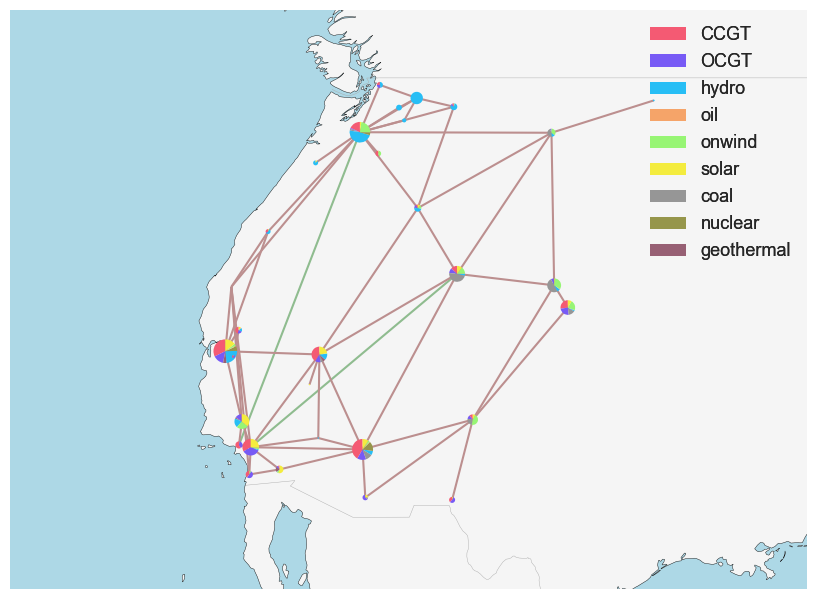

In [392]:
# Capacity maps - original network
from pypsa.plot import add_legend_patches
import cartopy.crs as ccrs
import random
import matplotlib.patches as mpatches

og_network = pypsa.Network('elec_s_30.nc')
carriers = og_network.generators.carrier.unique()
colors = ['#F45A73','#775AF5','#27BEF5','#F5A469','#97F574','#F4EC3E','#969696','#96964B','#976074']
og_network.mremove("Carrier", carriers) # remove previous iterations
og_network.madd("Carrier", carriers, color=colors)

fig = plt.figure()
ax = plt.axes(projection=ccrs.EqualEarth())
capacities = og_network.generators.groupby(["bus", "carrier"]).p_nom.sum()

og_network.plot(
    ax=ax,
    bus_sizes=capacities / 2e5,
    margin=0.2,
    color_geomap = True
)

add_legend_patches(ax, colors, carriers)
